In [3]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.text.all import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Mounted at /content/gdrive


In [4]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import math
from collections import defaultdict
import os

In [5]:
# Mount Google Drive to the Colab environment
from google.colab import drive
drive.mount('/content/drive')

# Find the news category on my google drive
import os
# Update the path with the mounted drive location
os.listdir( "/content/drive/MyDrive/EAI6010" )

Mounted at /content/drive


['NewsCategory_v2.zip',
 'module_3_fine_tuned_language_model',
 'news_category_classifier',
 'NewsCategory_v2',
 '__MACOSX']

In [6]:
print("Current directory:", os.getcwd())

Current directory: /content


In [7]:
print("Files in current directory:", os.listdir())
print("Files in drive directory:", os.listdir("/content/drive/MyDrive/EAI6010"))

Files in current directory: ['.config', 'drive', 'gdrive', 'sample_data']
Files in drive directory: ['NewsCategory_v2.zip', 'module_3_fine_tuned_language_model', 'news_category_classifier', 'NewsCategory_v2', '__MACOSX']


In [8]:
# Using Python's built-in zipfile module (recommended)
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/EAI6010/NewsCategory_v2.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/EAI6010/")

In [8]:
# The JSON isn't a valid format -- load it by line first
with open( os.path.join( "/content/drive/MyDrive/EAI6010/NewsCategory_v2", "News_Category_Dataset_v2.json" ), "r" ) as f:
  record_lines = f.readlines( )

# ...then parse each line
import json
record_jsons = list( )
for record_line in record_lines:
  record_json = json.loads( record_line )
  record_jsons.append( record_json )

# Show the first record
print( f"first record:\n{record_jsons[ 2 ]}" )

# We have the article's headline, short description, & category. This format
# isn't very handy to use with the fast.ai libraries though -- we need to
# do some additional formatting.

first record:
{'category': 'ENTERTAINMENT', 'headline': 'Hugh Grant Marries For The First Time At Age 57', 'authors': 'Ron Dicker', 'link': 'https://www.huffingtonpost.com/entry/hugh-grant-marries_us_5b09212ce4b0568a880b9a8c', 'short_description': 'The actor and his longtime girlfriend Anna Eberstein tied the knot in a civil ceremony.', 'date': '2018-05-26'}


In [9]:
# Let's filter everything to a subset of the classes because language models
# are really really slow to train

# Collect the classes
categories = set()
for record_json in record_jsons:
    categories.add(record_json['category'])
print(f"num. categories: {len(categories)}\n\ncategories:\n{categories}")

# Directly specify the categories you want
desired_categories = ['FOOD & DRINK', 'ARTS & CULTURE', 'TASTE', 'COMEDY',
                     'RELIGION', 'HEALTHY LIVING', 'THE WORLDPOST', 'TECH',
                     'TRAVEL', 'FIFTY']

# Use these specific categories as your subset
category_subset = desired_categories
print(f"\ncategory subset:\n{category_subset}")

# Make sure these two times I pick up the same 10 different classes

num. categories: 41

categories:
{'BUSINESS', 'WELLNESS', 'CRIME', 'BLACK VOICES', 'MONEY', 'GREEN', 'ARTS', 'STYLE & BEAUTY', 'RELIGION', 'WORLD NEWS', 'MEDIA', 'EDUCATION', 'TASTE', 'STYLE', 'LATINO VOICES', 'FOOD & DRINK', 'CULTURE & ARTS', 'FIFTY', 'PARENTING', 'WORLDPOST', 'SPORTS', 'DIVORCE', 'SCIENCE', 'HEALTHY LIVING', 'COLLEGE', 'HOME & LIVING', 'ENVIRONMENT', 'GOOD NEWS', 'TRAVEL', 'COMEDY', 'PARENTS', 'THE WORLDPOST', 'WEDDINGS', 'ARTS & CULTURE', 'WEIRD NEWS', 'POLITICS', 'TECH', 'ENTERTAINMENT', 'WOMEN', 'QUEER VOICES', 'IMPACT'}

category subset:
['FOOD & DRINK', 'ARTS & CULTURE', 'TASTE', 'COMEDY', 'RELIGION', 'HEALTHY LIVING', 'THE WORLDPOST', 'TECH', 'TRAVEL', 'FIFTY']


In [10]:
# Let's follow the convention of a folder per class with single files per
# record

# Reset the root directory if we need to -- we check and delete so this code is repeatable
root_dir_name = "news_by_category"
print( f"setting up '{root_dir_name}'" )
if os.path.exists( root_dir_name ):
  shutil.rmtree( root_dir_name )
os.mkdir( root_dir_name )

# Initialize the counts for each of the subset
category_to_count = dict( )
for category in category_subset:
  category_to_count[ category ] = 0

# Create a file for each record and put it in a subfolder named for the category
count = 0
total_words = 0 # we need to set a sequence length for the language model, so we should capture the typical lengths of the documents
for record in record_jsons:

  # Skip this record if its not one of the categories we are interested in
  category = record[ "category" ]
  if category not in category_subset:
    continue

  # Update the processed count and show the progress if we should
  count = count + 1
  if ( count % 10000 ) == 0:
    print( f"creating file for record {int(count/1000)}k" )

  # Setup the directory if it doesn't exist
  dir_path = os.path.join( root_dir_name, category )
  if not os.path.exists( dir_path ):
    os.mkdir( dir_path )

  # Build the document text and save the word length
  document_text = f"{record[ 'headline' ]} \n {record[ 'short_description' ]} \n " # document content is the headline + short description
  total_words = total_words + len( document_text.split( " " ) )

  # Save the document text to file
  category_count = category_to_count[ category ] + 1
  category_to_count[ category ] = category_count
  filename = f"{category}-{category_count}.txt"
  file_path = os.path.join( dir_path, filename )
  with open( file_path, "w" ) as f:
    f.write( document_text )

# Verify the directories
print( f"\nworking directory:\n{os.listdir( )}" )
print( f"\ndata directory:\n{os.listdir( root_dir_name )}" )
category_dir_path = os.path.join( root_dir_name, category_subset[ 0 ] )
print( f"\n'{category_dir_path}'':\n{os.listdir( os.path.join( root_dir_name, category_subset[ 0 ] ) )}" )
category_dir_path = os.path.join( root_dir_name, category_subset[ 1 ] )
print( f"\n'{category_dir_path}'':\n{os.listdir( os.path.join( root_dir_name, category_subset[ 1 ] ) )}" )

# Verify a document
with open( os.path.join( category_dir_path, f"{category_subset[ 1 ]}-1.txt" ), 'r' ) as f:
  document_content = f.readlines( )
  print( f"\ndocument content:\n{document_content}" )

# Calculate the average document length so we can intelligently set the sequence length (predict the next word give the input sequence)
avg_document_words = round( total_words / count )
print( f"\naverage number of words in a document = {avg_document_words}")

setting up 'news_by_category'
creating file for record 10k
creating file for record 20k
creating file for record 30k
creating file for record 40k

working directory:
['.config', 'drive', 'news_by_category', 'gdrive', 'sample_data']

data directory:
['RELIGION', 'TECH', 'COMEDY', 'TASTE', 'TRAVEL', 'FOOD & DRINK', 'ARTS & CULTURE', 'FIFTY', 'HEALTHY LIVING', 'THE WORLDPOST']

'news_by_category/FOOD & DRINK'':
['FOOD & DRINK-5596.txt', 'FOOD & DRINK-5246.txt', 'FOOD & DRINK-2875.txt', 'FOOD & DRINK-4599.txt', 'FOOD & DRINK-1478.txt', 'FOOD & DRINK-479.txt', 'FOOD & DRINK-553.txt', 'FOOD & DRINK-4642.txt', 'FOOD & DRINK-5952.txt', 'FOOD & DRINK-5383.txt', 'FOOD & DRINK-5843.txt', 'FOOD & DRINK-2511.txt', 'FOOD & DRINK-5074.txt', 'FOOD & DRINK-985.txt', 'FOOD & DRINK-3903.txt', 'FOOD & DRINK-5499.txt', 'FOOD & DRINK-900.txt', 'FOOD & DRINK-1417.txt', 'FOOD & DRINK-883.txt', 'FOOD & DRINK-2771.txt', 'FOOD & DRINK-3153.txt', 'FOOD & DRINK-724.txt', 'FOOD & DRINK-3666.txt', 'FOOD & DRINK-6216

# SVM Classifier
TD-IDF feature

In [11]:
def load_data_from_directory(root_dir_name):
    """Load text data and labels from directory structure"""
    texts = []
    labels = []

    for category in category_subset:  # Using your existing category_subset
        category_path = os.path.join(root_dir_name, category)
        if os.path.exists(category_path):
            for filename in os.listdir(category_path):
                if filename.endswith('.txt'):
                    with open(os.path.join(category_path, filename), 'r') as f:
                        text = f.read()
                        texts.append(text)
                        labels.append(category)

    return texts, labels

# Load the data
print("Loading data...")
texts, labels = load_data_from_directory('news_by_category')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=4
)

# Create TF-IDF features
print("Creating TF-IDF features...")
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train SVM classifier
print("Training SVM classifier...")
svm = LinearSVC(random_state=4)
svm.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = svm.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate perplexity
def calculate_perplexity(texts, vectorizer, model):
    """
    Calculate perplexity using a bag-of-words approach
    """
    # Transform texts to TF-IDF features
    features = vectorizer.transform(texts)

    # Get decision function scores (distance from the hyperplane)
    scores = model.decision_function(features)

    # Convert scores to probabilities using softmax
    def softmax(x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / np.sum(e_x, axis=1, keepdims=True)

    probs = softmax(scores)

    # Calculate log probabilities
    log_probs = np.log2(probs + 1e-10)  # Add small constant to avoid log(0)

    # Calculate average negative log probability
    avg_neg_log_prob = -np.mean(np.sum(log_probs, axis=1))

    # Calculate perplexity
    perplexity = 2 ** avg_neg_log_prob

    return perplexity

print("\nCalculating perplexity...")
perplexity = calculate_perplexity(X_test, tfidf, svm)
print(f"Perplexity: {perplexity:.4f}")

Loading data...
Creating TF-IDF features...
Training SVM classifier...

Accuracy: 0.7443

Classification Report:
                precision    recall  f1-score   support

ARTS & CULTURE       0.65      0.53      0.58       282
        COMEDY       0.75      0.76      0.75      1053
         FIFTY       0.56      0.37      0.44       270
  FOOD & DRINK       0.70      0.74      0.72      1254
HEALTHY LIVING       0.71      0.79      0.75      1334
      RELIGION       0.79      0.73      0.76       526
         TASTE       0.40      0.24      0.30       420
          TECH       0.79      0.73      0.76       448
 THE WORLDPOST       0.85      0.83      0.84       682
        TRAVEL       0.81      0.88      0.84      1955

      accuracy                           0.74      8224
     macro avg       0.70      0.66      0.67      8224
  weighted avg       0.73      0.74      0.74      8224


Calculating perplexity...
Perplexity: 840964727374.4385


# Native Baynes Classification Model
TD-IDF feature

In [15]:
def calculate_better_perplexity(texts, vectorizer, model):
    """
    Calculate perplexity using probabilities directly from Naive Bayes
    """
    features = vectorizer.transform(texts)

    # Use predict_proba instead of decision_function
    probs = model.predict_proba(features)

    # Calculate cross-entropy
    epsilon = 1e-10  # Small constant to avoid log(0)
    log_probs = np.log2(probs + epsilon)
    cross_entropy = -np.mean(np.sum(log_probs, axis=1))

    # Calculate perplexity
    perplexity = np.exp2(cross_entropy)

    return perplexity

# Train Naive Bayes
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

# Calculate accuracy
nb_pred = nb.predict(X_test_tfidf)
nb_accuracy = accuracy_score(y_test, nb_pred)
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")

# Calculate perplexity
nb_perplexity = calculate_better_perplexity(X_test, tfidf, nb)
print(f"Naive Bayes Perplexity: {nb_perplexity:.4f}")

# Print classification report for Naive Bayes
print("\nClassification Report for Naive Bayes:")
print(classification_report(y_test, nb_pred))

Naive Bayes Accuracy: 0.6809
Naive Bayes Perplexity: 2562150802434371.5000

Classification Report for Naive Bayes:
                precision    recall  f1-score   support

ARTS & CULTURE       0.89      0.06      0.11       282
        COMEDY       0.74      0.70      0.72      1053
         FIFTY       0.75      0.01      0.02       270
  FOOD & DRINK       0.67      0.81      0.73      1254
HEALTHY LIVING       0.61      0.82      0.70      1334
      RELIGION       0.91      0.45      0.60       526
         TASTE       1.00      0.00      0.01       420
          TECH       0.94      0.31      0.46       448
 THE WORLDPOST       0.79      0.81      0.80       682
        TRAVEL       0.65      0.92      0.76      1955

      accuracy                           0.68      8224
     macro avg       0.79      0.49      0.49      8224
  weighted avg       0.73      0.68      0.63      8224



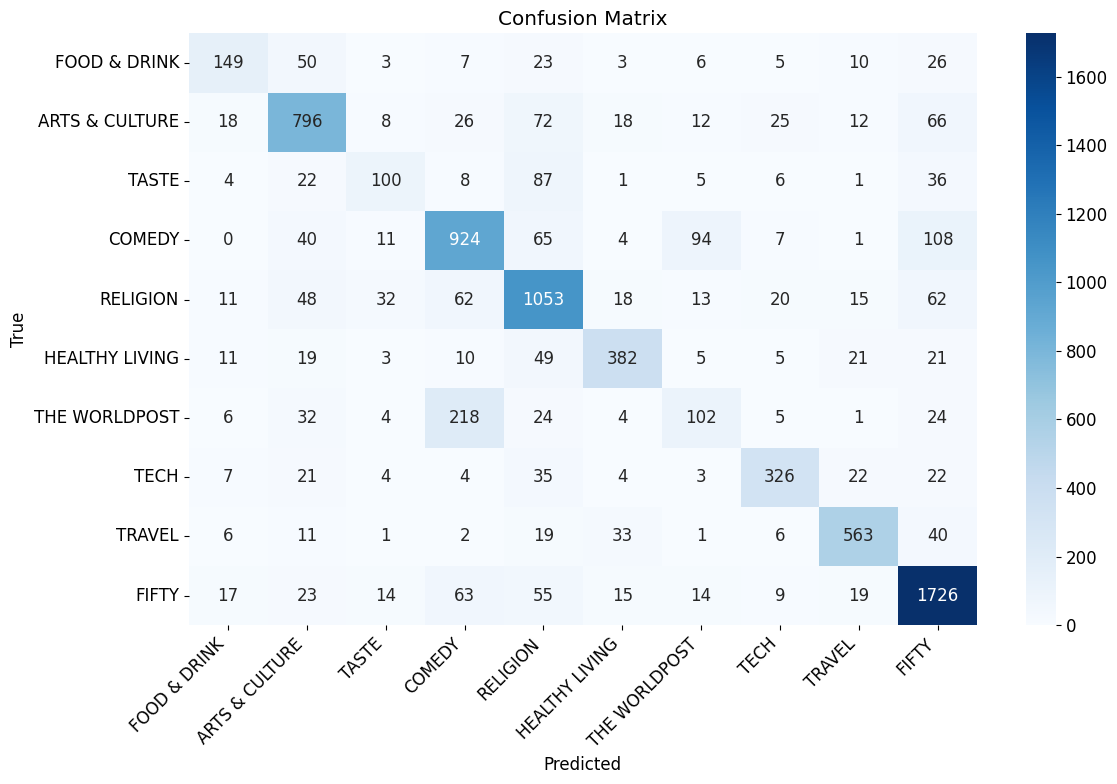


Model Statistics:
Number of features: 10000
Training samples: 32896
Test samples: 8224


In [17]:
# Save confusion matrix visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=category_subset,
            yticklabels=category_subset)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print model statistics
print("\nModel Statistics:")
print(f"Number of features: {X_train_tfidf.shape[1]}")
print(f"Training samples: {X_train_tfidf.shape[0]}")
print(f"Test samples: {X_test_tfidf.shape[0]}")

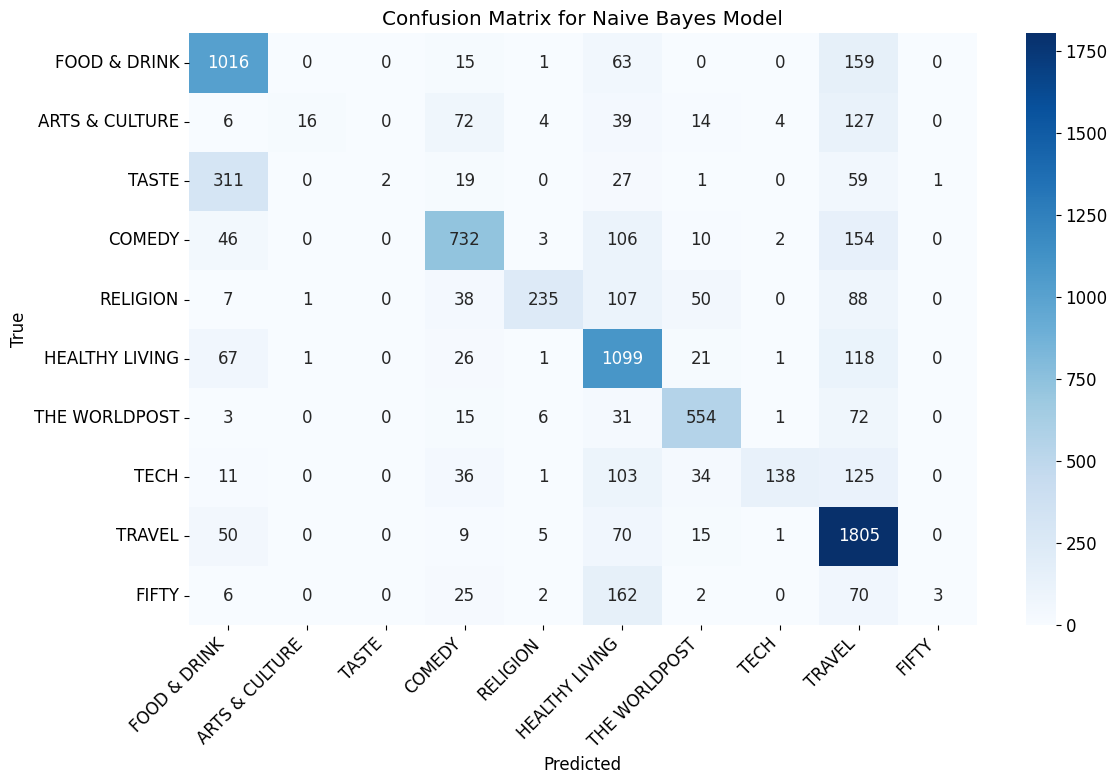

Model Statistics:
Number of features: 10000
Training samples: 32896
Test samples: 8224


In [19]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, nb_pred, labels=category_subset)
# Create visualization for confusion matrix For Native Baynes
plt.figure(figsize=(12, 8))
sns.heatmap(cm,
            annot=True,          # Show values in cells
            fmt='d',             # Format as integers
            cmap='Blues',        # Use blue color palette
            xticklabels=category_subset,  # Labels for x-axis
            yticklabels=category_subset)  # Labels for y-axis

# Set title and labels
plt.title('Confusion Matrix for Naive Bayes Model')
plt.xlabel('Predicted')
plt.ylabel('True')

# Rotate x-axis labels to prevent overlap
plt.xticks(rotation=45, ha='right')

# Adjust layout to ensure all labels are visible
plt.tight_layout()

# Display the plot
plt.show()

# Print model statistics
print("Model Statistics:")
print(f"Number of features: {X_train_tfidf.shape[1]}")
print(f"Training samples: {X_train_tfidf.shape[0]}")
print(f"Test samples: {X_test_tfidf.shape[0]}")